# Evaluate Model on Drifted Data

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
import joblib
from utils.evalUtils import calc_cm_metrics
from utils.evalUtils import print_confusion_matrix

In [2]:
%run -i ./scripts/PythonImports.py

Imports..


In [3]:
%run -i ./scripts/EvalPreperations.py

Set configs..
Read the data..
Shape of normal data: (105216, 17)
Shape of anormal data: (35040, 18)
Shape of drifted data: (35040, 18)
Save label..
Shape of anormal data: (35040, 17)
Shape of drifted data: (35040, 17)
Scale data..
Prepare data for PyTorch..


In [4]:
%run -i ./scripts/ReadSimpleAE.py

Load trained simple AE..
/Users/torge/Development/master/masterthesis_code/02_Experimente/AnomalyDetection/models/model_bib/20200302_firstAE_model.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)


In [5]:
%run -i ./scripts/ReadLogReg.py

Load trained LogReg..
LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


## Evaluate on Test data

In [7]:
losses_anormal = []
for val in anormal_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_anormal.append(loss.item())
    
s_losses_anormal = pd.Series(losses_anormal)

In [8]:
X_ano = s_losses_anormal.to_numpy()
X_ano = X_ano.reshape(-1, 1)
y_ano = [1 if x > 0 else 0 for x in s_labels]

In [9]:
predictions_ano = []
for val in X_ano:
    val = val.reshape(1,-1)
    pred = clf.predict(val)
    predictions_ano.append(pred[0])

In [10]:
cm = confusion_matrix(y_ano, predictions_ano)
tn, fp, fn, tp  = confusion_matrix(y_ano, predictions_ano).ravel()

In [11]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn, debug=True)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

----------------------------------------
TP: 2392
TN: 32543
FP: 0
FN: 105
----------------------------------------
Accuracy: 99.70034246572497
Precision: 99.99999999958195
Specifity: 93.15299842562096
Sensitivity: 95.79495394435004
F1-Score: 97.85232153794672


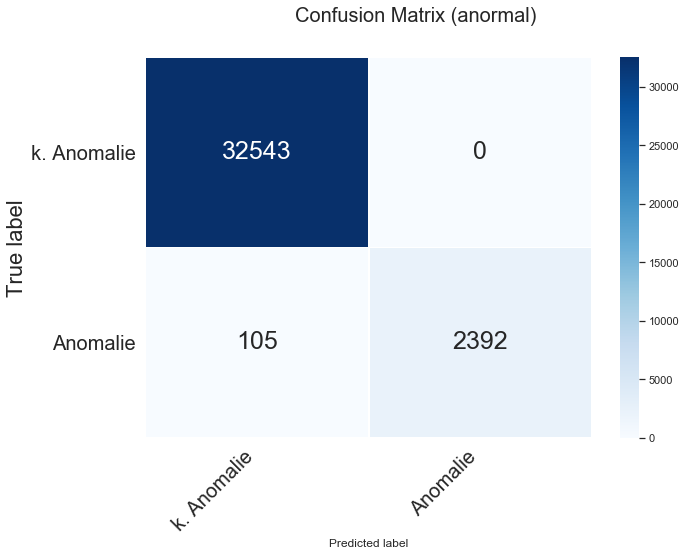

In [12]:
fig = print_confusion_matrix(cm, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix (anormal)', fontsize=20)
fn = os.path.join(fig_path, 'cm_anormal.pdf')
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

## Evaluate on drifted data

In [13]:
losses_drifted = []
for val in drifted_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_drifted.append(loss.item())
    
s_losses_drifted = pd.Series(losses_drifted)

In [14]:
drifted_ana = pd.DataFrame(drifted_torch_tensor.numpy())

In [15]:
drifted_ana['losses'] = s_losses_drifted

In [16]:
X = s_losses_drifted.to_numpy()
X = X.reshape(-1, 1)
y = np.zeros(len(X))

In [17]:
predictions = []
for val in X:
    val = val.reshape(1,-1)
    pred = clf.predict(val)
    predictions.append(pred[0])

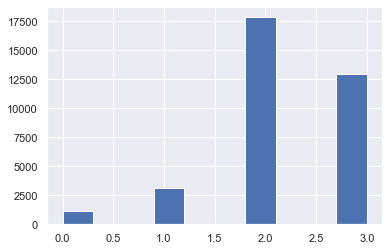

In [27]:
s_drift_labels.hist()

In [18]:
drift_labs = s_drift_labels
drift_labs.index = np.arange(len(drift_labs))

In [19]:
drifted_ana['preds'] = predictions
drifted_ana['drift_labels'] = drift_labs

In [20]:
drifted_ana.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,losses,preds,drift_labels
0,-0.361683,-0.340665,-0.195000,-0.226287,-0.533003,-0.619337,-0.464010,-0.465232,-0.463632,-0.448233,-0.934873,-0.937188,0.312905,0.358554,0.733022,-0.412400,-0.934690,0.000535,0,0.0
1,-0.426634,-0.405138,-0.254874,-0.286832,-0.590971,-0.664934,-0.534886,-0.536075,-0.534497,-0.519722,-0.885071,-0.888276,0.375630,0.423473,0.774954,-0.480219,-0.884749,0.000788,0,0.0
2,-0.488153,-0.466242,-0.311690,-0.344285,-0.646011,-0.708231,-0.602131,-0.603269,-0.601737,-0.587541,-0.840568,-0.844077,0.435098,0.485023,0.811966,-0.544449,-0.840122,0.001352,0,0.0
3,-0.546848,-0.524637,-0.365881,-0.399325,-0.698175,-0.748869,-0.666872,-0.667940,-0.666483,-0.652450,-0.799833,-0.803441,0.491931,0.543870,0.845695,-0.605699,-0.799273,0.001800,0,0.0
4,-0.602720,-0.580341,-0.417474,-0.451976,-0.747491,-0.786874,-0.729136,-0.730112,-0.728764,-0.714477,-0.762977,-0.766593,0.546162,0.600049,0.876147,-0.663961,-0.762314,0.001548,0,0.0


In [21]:
tmp = drifted_ana[drifted_ana['preds'] > 0]
print(len(tmp))

3324


In [22]:
tmp2 = tmp[tmp['drift_labels'] > 0.0]
print(len(tmp2))

3324


In [23]:
tmp2.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,losses,preds,drift_labels
7877,-0.693957,-0.679159,-0.218775,-0.557234,-0.803828,-0.801700,-1.192845,-1.062686,-1.098140,-1.043136,-0.745196,-0.748796,0.632224,505.298035,0.890825,-0.752044,-0.744483,15052.232422,1,1.0
6954,-0.049914,-0.088760,0.461931,-0.733892,0.762583,0.811415,-0.895366,-0.455590,-0.495252,-0.575435,-0.185026,-0.193453,0.013948,1504.390137,-0.023136,0.002999,-0.188205,133288.562500,1,1.0
6676,0.014792,0.005067,0.494389,-0.897826,0.891062,0.759365,-0.609027,-0.325262,-0.365245,-0.513118,-0.149604,-0.157801,-0.061719,1965.044312,-0.052312,0.097796,-0.152694,227349.625000,1,1.0
7712,0.294559,0.270167,1.140414,0.148010,0.369403,0.289910,-0.816573,-0.533547,-0.572605,-0.373397,0.244892,0.239354,-0.322771,1505.656616,-0.377342,0.296776,0.242833,133512.812500,1,1.0
9150,0.283478,0.253196,1.083189,0.210004,0.113410,-0.010949,-0.812956,-0.614878,-0.653612,-0.424303,0.321425,0.316421,-0.304389,1419.776489,-0.440420,0.274756,0.319572,118725.093750,1,1.0
8235,0.502171,0.499700,1.556686,0.538556,0.366237,0.197462,-0.696283,-0.484099,-0.523132,-0.211745,0.227445,0.221786,-0.537172,1693.472046,-0.362964,0.499400,0.225340,168876.484375,1,1.0
6630,-0.604190,-0.595395,-0.087168,-0.485295,-0.669846,-0.653166,-1.183413,-1.013440,-1.049731,-0.979137,-0.795886,-0.799498,0.545329,569.955933,0.848958,-0.656773,-0.795315,19153.513672,1,1.0
7636,-0.251814,-0.262715,0.108329,-0.961043,0.697707,0.645311,-0.762401,-0.446203,-0.486041,-0.692352,-0.407293,-0.417135,0.198939,1661.599243,0.159913,-0.178857,-0.411004,162583.031250,1,1.0
8712,0.147629,0.145569,0.772513,-0.276262,0.193013,-0.077542,-0.582487,-0.528039,-0.567217,-0.496170,0.382558,0.377987,-0.183620,1770.421997,-0.490810,0.174309,0.380870,184564.000000,1,1.0
6284,-0.141483,-0.178180,0.302593,-0.906123,0.780961,0.839423,-0.902373,-0.457078,-0.496813,-0.630526,-0.217095,-0.225730,0.101575,1494.923584,0.003278,-0.081107,-0.220354,131617.437500,1,1.0


In [24]:
cm = confusion_matrix(y, predictions)
tn, fp, fn, tp  = confusion_matrix(y, predictions).ravel()

In [25]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn, debug=True)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

----------------------------------------
TP: 0
TN: 31716
FP: 3324
FN: 0
----------------------------------------
Accuracy: 90.51369863011116
Precision: 0.0
Specifity: 99.99999999996847
Sensitivity: 0.0
F1-Score: 0.0


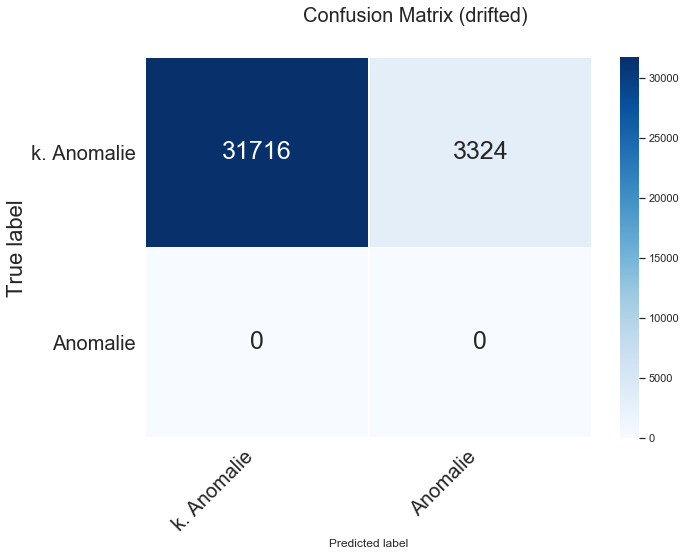

In [26]:
fig = print_confusion_matrix(cm, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix (drifted)', fontsize=20)
fn = os.path.join(fig_path, 'cm_drifted.pdf')
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

## Evaluate on drifted & anormal Data

In [28]:
fn = os.path.join(data_path, 'anomalous_drifted_data_y_2023_reduced_more_cos_phi.h5')
df_ano_drifted_data = pd.read_hdf(fn, key='df')

In [29]:
s_ano_labels = df_ano_drifted_data['anomaly_labels'].copy()
s_drift_labels = df_ano_drifted_data['drift_labels'].copy()

df_ano_drifted_data.drop('anomaly_labels', axis=1, inplace=True)
df_ano_drifted_data.drop('drift_labels', axis=1, inplace=True)

In [30]:
scaled_drifted_ano = scaler_train.transform(df_ano_drifted_data.to_numpy())

In [31]:
drifted_ano_torch_tensor = torch.from_numpy(scaled_drifted_ano).type(torch.FloatTensor)

In [32]:
losses_drifted_ano = []
for val in drifted_ano_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_drifted_ano.append(loss.item())
    
s_losses_drifted_ano = pd.Series(losses_drifted_ano)

In [33]:
X_drifted_ano = s_losses_drifted_ano.to_numpy()
X_drifted_ano = X_drifted_ano.reshape(-1, 1)
y_drifted_ano = [1 if x > 0 else 0 for x in s_ano_labels]

In [34]:
predictions_drifted_ano = []
for val in X_drifted_ano:
    val = val.reshape(1,-1)
    pred = clf.predict(val)
    predictions_drifted_ano.append(pred[0])

In [35]:
cm = confusion_matrix(y_drifted_ano, predictions_drifted_ano)
tn, fp, fn, tp  = confusion_matrix(y_drifted_ano, predictions_drifted_ano).ravel()

In [36]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn, debug=True)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

----------------------------------------
TP: 2403
TN: 29230
FP: 3313
FN: 94
----------------------------------------
Accuracy: 90.27682648399251
Precision: 42.03988803351638
Specifity: 92.4035026712318
Sensitivity: 96.23548257870951
F1-Score: 58.51698526718797


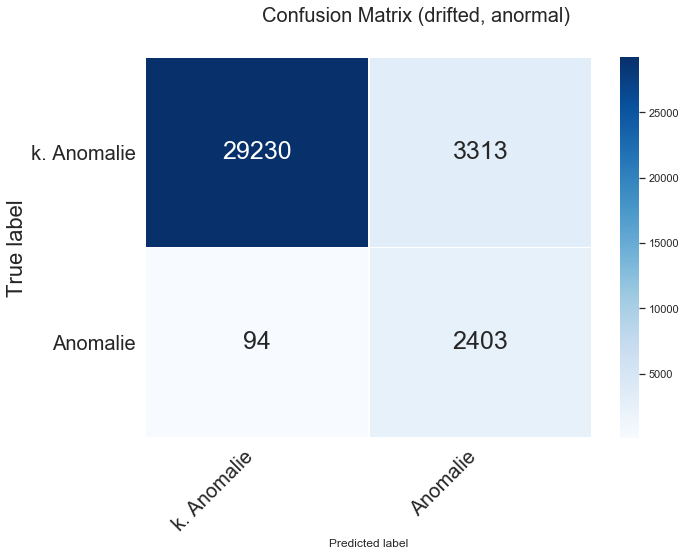

In [37]:
fig = print_confusion_matrix(cm, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix (drifted, anormal)', fontsize=20)
fn = os.path.join(fig_path, 'cm_drifted_anormal.pdf')
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )